### Startup file for quail_volcano

This is a startup example file for running the vulcanian case in quail_volcano. To start, check that we're on the correct git branch (`git branch` to see branch, and if necessary, `git checkout fragmixture`). To update the code, use `git pull origin fragmixture`. If submodules need to be updated, navigate to the submodule folder (`src/compressible_conduit_steady`) anduse git pull (`git pull origin main`) to update the submodule.

Here, we'll be working in the folder `scenarios/tungurahua_vulcanian`. An input file `conduit_sub0.py`, for running the code on one CPU, is provided.

First, run the code to compute the numerical solution. To do this, add quail to the python path. Using the absolute path, this is "[put your quail_volcano repository parent directory here]\\quail_volcano\\src\\quail". Once this is done, navigate to `scenarios/tungurahua/vulcanian` and run
```
  python quail conduit_sub0.py
```
which will run the file `quail` in python, and send as arg `conduit_sub0.py`, which is the input file. This command will start the simulation, which first computes the initial condition, and then starts running the compressible flow model. The model may take a while, but we don't need the whole simulation for this startup notebook. Note: you may have to use `python3` (Sherlock) instead of `python`.

Although the console output is done at every step, the solution is saved every `WriteInterval` steps, as specified in the input file (`conduit_sub0.py`). These solutions are saved as `.pkl` files, which are python binaries. In this case, the `.pkl` file saves the entire solver object. We'll read the .pkl file in this notebook and mess around with the variables.

------

In the following, we set up postprocessing steps for the numerical solution for your local machine. We'll need a python kernel for the notebook, so set that up on your end before proceeding.

In [19]:
# Specify quail source directory
source_dir = r"C:\Users\Fredric\Documents\Volcano\quail_volcano\src"
# Specify data directory (where the .pkl files are)
target_dir = r"C:\Users\Fredric\Documents\Volcano\quail_volcano\scenarios\tungurahua_vulcanian"
# Specify pkl filename template
# filename_template = lambda time_idx: f"tungurahua_test_conduit_sub0_{time_idx}.pkl"
filename_template = lambda time_idx: f"tungurahua_StaticPlugtest_conduit_sub0_{time_idx}.pkl"


In [20]:
# Import standard libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.interpolate

In [21]:
# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

os.chdir(target_dir)

In [22]:
# Here we define the file-read interface. Using filename_template we defined
# before, we use quail's readwritedatafiles module to read in the .pkl files.
solver_from = lambda file_idx: readwritedatafiles.read_data_file(
  filename_template(file_idx))

Once the file input is set up, we can access the data in the .pkl files. Saved in the .pkl file is the `solver` object, which contains the numerical solver's universe. `solver` is roughly laid out like this:
```
  solver
  ├---time
  ├---state_coeffs
  ├---physics
  ├---mesh
  └---other stuff...
```
Here `state_coeffs` represents the solution at the mesh nodes. We'll see what this consists of, visually, in the next box. The `physics` object holds the physics information (source terms, boundary conditions, initial conditions...)---these are mainly functions that can be called to evaluate variables. These functions are defined in `src/physics/multiphasevpT/functions.py`. Finally, `mesh` contains the information about the mesh. Most of the contents of `mesh` are needed to deal with element volumes and faces for two-dimensional models; for one-dimensional models, we will typically only need the node coordinates from the mesh.

There are more attributes in `solver`. To see all of them, we will run `dir(solver)`.

In the following, we will read a solver object, and manipulate its attributes to create a plot of pressure.

In [23]:
# We defined `solver_from` above: this is a convenience tool to quickly read in a file with the given index.
solver = solver_from(9)

In [24]:
# Let's take a look at the time
print(f"The solver is a snapshot at t = {solver.time}.")
# The state_coeffs attribute is the solution at time t 
print(f"solver.state_coeffs is a np.array with shape {solver.state_coeffs.shape}")

The solver is a snapshot at t = 0.005400000000000159.
solver.state_coeffs is a np.array with shape (200, 3, 8)


In the above box, we inspected the shape of `solver.state_coeffs`. This is a multi-dimensional array with the shape
```
  (nelems, nbasis, nstates)
```
where `nelems` is the number of elements we set in the input file (in file `conduit_sub0.py`, attribute `NumElemsX`), `nbasis` is the number of basis functions that live in an element, and `nstates` is the number of state variables.

First, we'll define `nbasis`. In the input file `conduit_sub0.py`, we set attribute `SolutionOrder`. This sets the polynomial order for the approximation within each element. For example, if `SolutionOrder` is set to 2, we are approximating the solution inside each element as a quadratic function. A quadratic function is fully specified by three distinct points, so `nbasis` is 3 in this case. These 3 data points are evenly spaced within the element.

Secondly, we'll list what corresponds to the 8 states. We have three phase partial densities (air, water vapor, magma), one momentum variable, and one energy variable. Then, we have the partial densities of total water, crystals, and fragmented magma. These add up to eight state variables. Partial density here means the mass of that phase per total volume. We'll have examples later.

In the following, we'll show an example of what the solution looks like, for the mixture density.

In [25]:
# Here we'll define some utilities for plotting a discontinuous Galerkin solution.

def elt_index(x_in:float, node_coords):
  ''' Maps location to element index. '''
  if x_in <= node_coords[0]:
    return 0
  if x_in >= node_coords[-1]:
    return node_coords.shape[0]-2
  return node_coords.shape[0] \
    - np.argmax((x_in >= node_coords)[::-1]) - 1

def eval_soln(x, x_elems, proj_vals, node_coords):
  ''' Evaluates piecewise polynomial solution. At element faces, returns value
   from the left element. '''
  # Wrap x in array if scalar
  x = np.asarray(x)
  y = np.empty_like(x)
  # Piecewise evaluation
  for i, _x in enumerate(x.ravel()):
    # JIT interpolation construction from scipy lagrange interp interface
    _elt_idx = elt_index(_x, node_coords)
    _poly = scipy.interpolate.lagrange(
      x_elems[_elt_idx,:,0].ravel(),
      proj_vals[_elt_idx,:,0])
    y.ravel()[i] = _poly(_x)
  return y

def plot_DGsoln(x_elems, vals, node_coords):
  ''' Plots piecewise polynomial solution. Uses a built-in x-axis. '''
  # Define colors of polynomial in each element; loops around
  colorcycle = ["red", "black"]
  for elt_idx in range(x_elems.shape[0]):
    # Define points in current element to plot at
    x_loc = np.linspace(node_coords[elt_idx], node_coords[elt_idx+1], 3)
    # Define the local polynomial representation of vals
    _poly = scipy.interpolate.lagrange(
      x_elems[elt_idx,:,0].ravel(),
      vals[elt_idx,:,0])
    # Add plot
    plt.plot(x_loc, _poly(x_loc), '.-',
             color=colorcycle[elt_idx % len(colorcycle)])

Here's the mixture density as a function of x. Color alternates red-black to highlight adjacent elements.


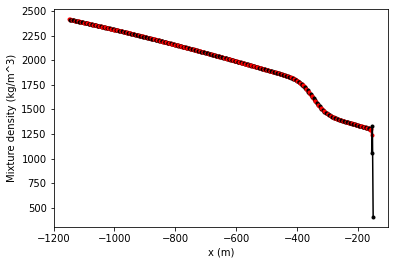

In [26]:
# Extract the solution from solver
U = solver.state_coeffs
# Extract the node coordinates
x_elems = solver.elem_helpers.x_elems

print("Here's the mixture density as a function of x. Color alternates red-black to highlight adjacent elements.")
plt.figure()
plot_DGsoln(x_elems, U[...,0:3].sum(axis=-1, keepdims=True), solver.mesh.node_coords)
plt.xlabel("x (m)")
plt.ylabel("Mixture density (kg/m^3)")
plt.draw()

Same plot, but zoomed into the middle of the domain:
The element is the quadratic function connecting the three points of the same color.
Note that the solution can be discontinuous at element boundaries.


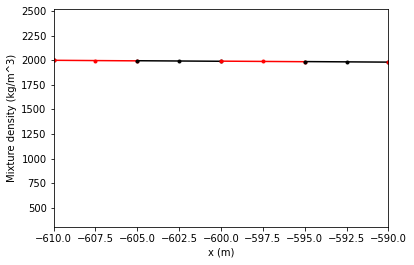

In [27]:
plt.figure()
plot_DGsoln(x_elems, U[...,0:3].sum(axis=-1, keepdims=True), solver.mesh.node_coords)
plt.xlim(-610, -590)
plt.xlabel("x (m)")
plt.ylabel("Mixture density (kg/m^3)")
print("Same plot, but zoomed into the middle of the domain:")
print("The element is the quadratic function connecting the three points of the same color.")
print("Note that the solution can be discontinuous at element boundaries.")
plt.draw()

#### Accessing the data
Now that we know what the solution should look like, we'll do some common data manipulation exercises to plot various useful quantities.

In [28]:
# Let's check x_elem's shape
solver.elem_helpers.x_elems.shape

(200, 3, 1)

The shape of x_elems is `(n_elems, n_basis, 1)`. This is the same as `state_coeffs`, but with 1 instead of 8 in the last axis. For most purposes, it is inconvenient to deal with the discontinuity at the overlap of each element. One quick way to get some information is by taking the middle point of the solution, i.e., look at `solver.elem_helpers.x_elems[:,1,0]`. Here the colon (`:`) indicates to take all entries along that axis. Below we use this to plot the partial densities of air, water, and magma.

In [29]:
# Unpack state_coeffs
partialDensityA  = solver.state_coeffs[:,:,0]  # Air (this is present for numerical stability for 2D-coupled simulations; this can be turned off in input)
partialDensityWv = solver.state_coeffs[:,:,1]  # Exsolved water mass per unit mixture volume
partialDensityM  = solver.state_coeffs[:,:,2]  # Liquid magma (including dissolved water, crystals) mass per unit mixture volume
energyDensity    = solver.state_coeffs[:,:,3]  # Total energy per unit mixture volume
momentumDensity  = solver.state_coeffs[:,:,4]  # Total momentum per unit mixture volume
partialDensityWt = solver.state_coeffs[:,:,5]  # Total water mass per unit mixture volume
partialDensityC  = solver.state_coeffs[:,:,6]  # Crystal mass per unit mixture volume
partialDensityF  = solver.state_coeffs[:,:,7]  # Total fragmented magma per unit mixture volume

# Grab the node coordinate of the middle point in each element
x_mid = solver.elem_helpers.x_elems[:,1,0]

Text(0, 0.5, 'Exsolved magma mass / total volume')

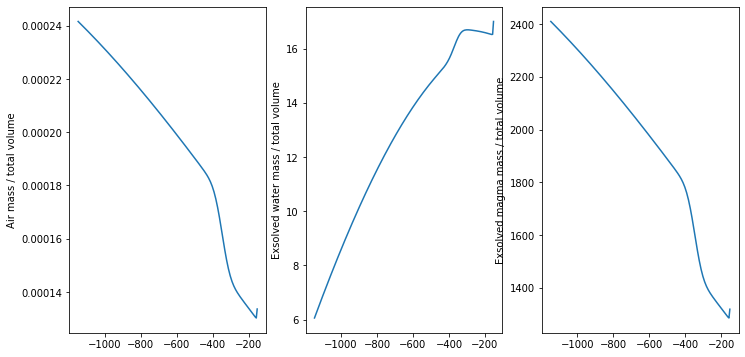

In [30]:
# Plot the partial densities of each phase. We use [:,1] to take the middle value
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.plot(x_mid, partialDensityA[:,1])
plt.ylabel("Air mass / total volume")
plt.subplot(1,3,2)
plt.plot(x_mid, partialDensityWv[:,1])
plt.ylabel("Exsolved water mass / total volume")
plt.subplot(1,3,3)
plt.plot(x_mid, partialDensityM[:,1])
plt.ylabel("Exsolved magma mass / total volume")

We do the same for the total water, crystals, and fragmented magma. These "component" densities are at the end of state_coeffs because they don't appear in the equation of state (i.e., pressure calculations do not make use of these variables; only exsolution and drag terms use these variables).

Text(0, 0.5, 'Fragmented magma mass / total volume')

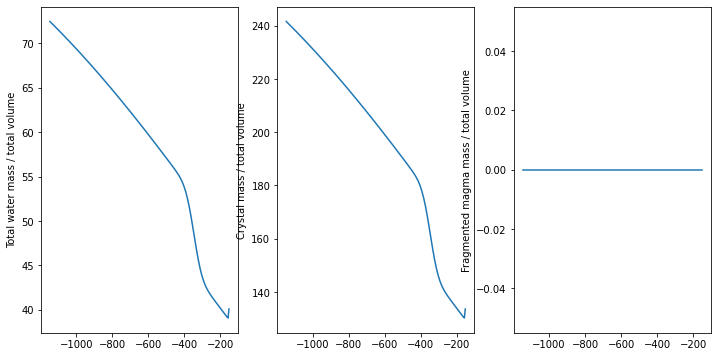

In [31]:
# Plot the partial densities of each extra component. We use [:,1] to take the middle value
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.plot(x_mid, partialDensityWt[:,1])
plt.ylabel("Total water mass / total volume")
plt.subplot(1,3,2)
plt.plot(x_mid, partialDensityC[:,1])
plt.ylabel("Crystal mass / total volume")
plt.subplot(1,3,3)
plt.plot(x_mid, partialDensityF[:,1])
plt.ylabel("Fragmented magma mass / total volume")

Here's how we would calculate fractions.

First, we show mass fraction of exsolved water vapor. The partial density of water vapor is equal to the mass fraction of water vapor (mass of water vapor divided by mass of mixture) times the mixture density (mass of mixture per volume of mixture). To get the mixture density, we sum up the partial densities of air, water vapor, and magma. Then, we divide the partial density of water vapor by the mixture density.

Second, we calculate the crystal fraction in the magma. This is the fraction of crystal mass per magma mass (we assume in this model that the crystal density and the magma density are the same). In this case, we would divide crystal partial density by the magma partial density.

Third, we calculate the fraction of magma fragmented. This is the partial density of fragmented magma divided by the partial density of magma.

Note that the crystal fraction increases as the water is exsolved from the magma, decreasing the amount of magma solution but not the amount of crystals.
Secondly, the fragmented magma goes rather smoothly from 0 to 1 through the (numerically smoothed) fragmentation front. 


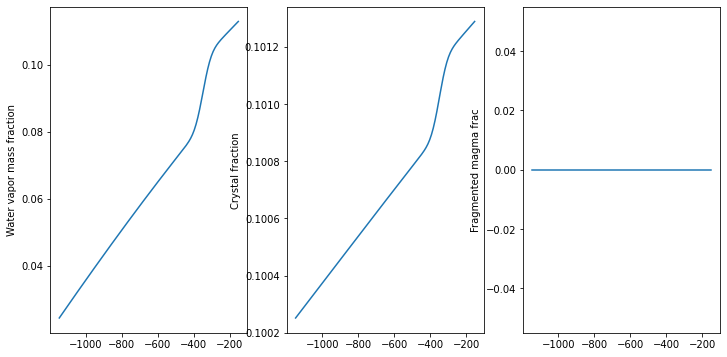

In [32]:
# Compute mixture density
rho = partialDensityA + partialDensityWv + partialDensityC
# Compute water vapor mass fraction
yWv = partialDensityWv / rho

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.plot(x_mid, yWv[:,1])
plt.ylabel("Water vapor mass fraction")

# Compute crystal volume fraction
crystal_frac = partialDensityC / partialDensityM
plt.subplot(1,3,2)
plt.plot(x_mid, crystal_frac[:,1])
plt.ylabel("Crystal fraction")

# Compute fragmented magma fraction
frag_frac = partialDensityF / partialDensityM
plt.subplot(1,3,3)
plt.plot(x_mid, frag_frac[:,1])
plt.ylabel("Fragmented magma frac")

print("Note that the crystal fraction increases as the water is exsolved from the magma, decreasing the amount of magma solution but not the amount of crystals.")
print("Secondly, the fragmented magma goes rather smoothly from 0 to 1 through the (numerically smoothed) fragmentation front. ")

Finally, we look at other useful quantities like pressure. This is complicated to compute (need equation of state of the mixture). Fortunately, these are already implemented while solving the equations, and can be accessed through `solver.physics`. Example below.

In [33]:
# Compute pressure using physics attribute
p = solver.physics.compute_variable("Pressure", solver.state_coeffs)
print(f"The shape of p is {p.shape}.")

The shape of p is (200, 3, 1).


Note that here we have selected the middle data point through [:,1,0]. We often have to play this shape game, so it is very useful to use the .shape often!


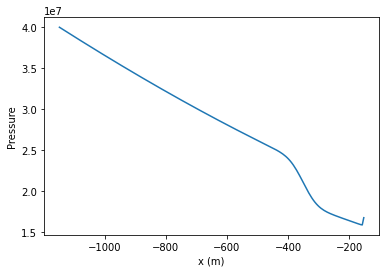

In [34]:
# Plot pressure
plt.plot(x_mid, p[:,1,0])
plt.xlabel("x (m)")
plt.ylabel("Pressure")
print("Note that here we have selected the middle data point through [:,1,0]. We often have to play this shape game, so it is very useful to use the .shape often!")

Below is a list of variables that can be computed through `compute_variable`. These can be found in `src/physics/multiphasevpT.py > class AdditionalVariables`

In [35]:
# Pressure
p = solver.physics.compute_variable("Pressure", solver.state_coeffs)
# Temperature
T = solver.physics.compute_variable("Temperature", solver.state_coeffs)
# Internal energy density (energy per unit mixture volume)
e_int_per_volume = solver.physics.compute_variable("InternalEnergy", solver.state_coeffs)
# Sound speed
c = solver.physics.compute_variable("SoundSpeed", solver.state_coeffs)
# Velocity in the conduit direction
u = solver.physics.compute_variable("XVelocity", solver.state_coeffs)
# Phase volume fractions
volFracA = solver.physics.compute_variable("volFracA", solver.state_coeffs)
volFracWv = solver.physics.compute_variable("volFracWv", solver.state_coeffs)
volFracM = solver.physics.compute_variable("volFracM", solver.state_coeffs)
# Signed friction term in momentum balance; proportional to wall shear stress
volumetric_drag = solver.physics.compute_variable("Drag", solver.state_coeffs)

Go ahead and try to plot some of these:

In [36]:
# try plt.plot(x_mid, <quantity here>[:,1,0])